In [121]:
import numpy as np
import matplotlib.pyplot as plt
import csv

In [122]:
""" IMPORTING DATA """

def import_data(file_name):
    data = []
    label = []
    with open(file_name, 'r') as csvfile:
        csvreader = csv.reader(csvfile)

        # skip first row because it has labels
        next(csvreader)
        data_indices = [1,2,3,4,5,7,8,9,10]
        class_index = 6

        for row in csvreader:
            data.append([row[i] for i in data_indices])
            label.append(row[class_index])

    # Convert the list to a numpy array
    data_array = np.array(data)

    # add bias
    bias = np.ones((len(data_array), 1))
    data_array = np.hstack((bias, data_array))

    data_array = data_array.astype(np.float32)
    label_array = np.array(label)
    label_array = label_array.astype(np.float32)
    print(f'label shape: {label_array.shape}')

    # here, we're setting the label to be 1 if a positive quantity is in label, otherwise it's -1
    label_array = np.where(label_array > 0.01, 1, -1)
    label_array = np.reshape(label_array, (len(label_array), 1))

    class_a_count = np.sum(label_array == -1)
    class_b_count = np.sum(label_array == 1)
    print(f'label statistics: class -1 {class_a_count}, class 1 {class_b_count}, baseline accuracy: {np.maximum(class_a_count, class_b_count)/(len(data_array))}')
    return data_array, label_array

def split_data(X, Y, test_ratio):
    num_test = int(len(X) * test_ratio)
    test_indices = np.random.choice(len(X), num_test, replace=False)
    Xtest = X[test_indices, :]
    Ytest = Y[test_indices, :]

    X = np.delete(X, test_indices, axis=0)
    Y = np.delete(Y, test_indices, axis=0)
    return X, Y, Xtest, Ytest

In [123]:
class NeuralNetwork():

    def __init__(self, layer_sizes):
        self.weights = []

        # initializing weights to small random values
        for i in range(1, len(layer_sizes)):
            self.weights.append(np.random.rand(layer_sizes[i], layer_sizes[i - 1]) * 0.1)
    
    def tanh(self, x):
        return np.tanh(x)

    def d_tanh(self, x):
        return 1 - np.power(np.tanh(x), 2)

    def output_func(self, X):
        return np.sign(X)
    
    # returns the final classification result
    def predict(self, X):
        A_0 = X.T
        A_1 = self.weights[0] @ A_0
        A_1 = self.tanh(A_1)
        A_2 = self.weights[1] @ A_1
        A_2 = self.output_func(A_2.T)
        return A_2
    
    # returns full history of forward so we can perform backpropagation
    def forward(self, X):
        A_0 = X
        A_1 = self.weights[0] @ A_0
        A_1 = self.tanh(A_1)
        A_2 = self.weights[1] @ A_1
        return (A_0, A_1, A_2)
    
    def backward(self, X, Y):
        A_0 = X
        A_0 = A_0.reshape((len(A_0), 1))

        # forward propagation
        A_0, A_1, A_2 = self.forward(A_0)

        # backward: error of output layer
        dA_2 = A_2 - Y

        # backward: compute weight gradient of layers
        dW_1 = dA_2 @ A_1.T
        dA_1 = self.weights[1].T @ dA_2 * self.d_tanh(A_1)
        dW_0 = dA_1 @ A_0.T

        # final gradient
        weight_gradients = [dW_0, dW_1]
        return weight_gradients

    
    def train(self, X, Y, total_epoch, learning_rate=0.03, learning_rate_decay=0.8):
        print("beginning training")
        accuracy_history = np.zeros((total_epoch + 1,))
        for epoch in range(total_epoch):

            # variable learning rate adjustment
            # TODO: better decay algorithm, such as checking error slope
            if epoch % (total_epoch // 10) == 0:
                learning_rate *= learning_rate_decay
                print(f"epoch {epoch} with learning rate {np.around(learning_rate, 4)}")

            for i in range(0, len(X)):

                weight_gradients = self.backward(X[i], Y[i])
                # subtract the gradient from the weights
                for j in range(len(self.weights)):
                    self.weights[j] -= learning_rate * weight_gradients[j]

            accuracy = self.test(X, Y)
            accuracy_history[epoch + 1] = accuracy
            if epoch % (total_epoch // 10) == 0:
                print(f'training accuracy: {np.around(accuracy, 5)}')
        
        return accuracy_history
            

    def test(self, X, Y):
        results = self.predict(X)
        num_incorrect = np.sum(np.abs(0.5 * (Y - results)))
        accuracy = 1 - (num_incorrect/len(X))
        return accuracy

    def correct(self, x, ans):
        return np.sign(x) == np.sign(ans)

label shape: (3654,)
label statistics: class -1 2079, class 1 1575, baseline accuracy: 0.5689655172413793
Shapes: X: (3289, 10), Y: (3289, 1), Xtest: (365, 10), Ytest: (365, 1)
beginning training
epoch 0 with learning rate 0.0064
training accuracy: 0.71085
epoch 10 with learning rate 0.0041
training accuracy: 0.73275
epoch 20 with learning rate 0.0026
training accuracy: 0.74187
epoch 30 with learning rate 0.0017
training accuracy: 0.74308
epoch 40 with learning rate 0.0011
training accuracy: 0.74673
epoch 50 with learning rate 0.0007
training accuracy: 0.7446
epoch 60 with learning rate 0.0004
training accuracy: 0.74886
epoch 70 with learning rate 0.0003
training accuracy: 0.75129
epoch 80 with learning rate 0.0002
training accuracy: 0.7522
epoch 90 with learning rate 0.0001
training accuracy: 0.75068


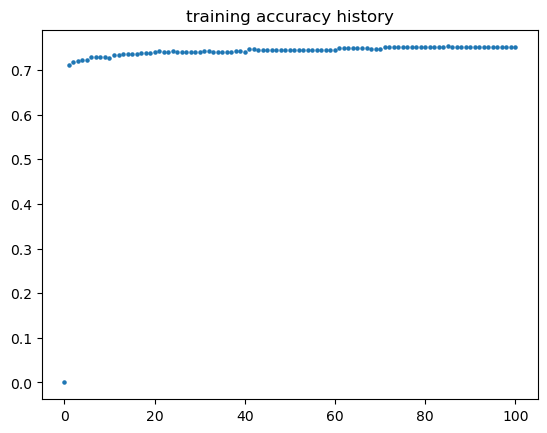

TESTING ACCURACY: 0.7780821917808219


In [124]:
"""TESTING"""

file = '../../Data/weather/weather_prediction_dataset.csv'
X, Y = import_data(file)

def custom_nn():
    Xtrain, Ytrain, Xtest, Ytest = split_data(X, Y, 0.1)
    print(f'Shapes: X: {Xtrain.shape}, Y: {Ytrain.shape}, Xtest: {Xtest.shape}, Ytest: {Ytest.shape}')
    network1 = NeuralNetwork([10, 20, 1])
    total_epoch = 100
    error_graph = network1.train(Xtrain, Ytrain, total_epoch, 0.01, 0.64)

    # plotting training accuracy
    plt.scatter(np.linspace(0, total_epoch, len(error_graph)), error_graph, s=5)
    plt.title("training accuracy history")
    plt.show()

    accuracy = network1.test(Xtest, Ytest)
    print(f"TESTING ACCURACY: {accuracy}")

custom_nn()

In [125]:
import torch
from sklearn.model_selection import train_test_split

In [126]:
def torch_nn():
    Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, test_size=0.1, random_state=0)
    print(f'Shapes: X: {Xtrain.shape}, Y: {Ytrain.shape}, Xtest: {Xtest.shape}, Ytest: {Ytest.shape}')
    

torch_nn()

Shapes: X: (1827, 10), Y: (1827, 1), Xtest: (1827, 10), Ytest: (1827, 1)
